在使用SOTA模型的时候会遇到模型过大推理过慢的问题。在不损失模型精度的情况下如何解决该问题呢？
四种技巧来到达该目的:
- knowledge distillation: 知识蒸馏
- **quantization: 模型量化**
- pruning: 模型减枝
- graph optimization with the Open Neural Network Exchange (ONNX): 计算图优化

这些方法也可以整合使用

In [1]:
import torch
from transformers import pipeline
from pathlib import Path
from datasets import load_dataset
from datasets import load_metric
from time import perf_counter
import numpy as np
from tqdm.auto import tqdm
from rich.console import Console
cs = Console()

# 案例：意图预估（Intent Detection）

识别客户一段描述内容的主要意图，
比如客户说："Hey, I’d like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"

我们的系统需要识别为： `Car Rental` 之后触发相应的动作和响应。另外，为了在生产环境中保持健壮，我们的分类器还需要能够处理范围外的查询。

作为baseline, 我们fine-tuned 了一个 `BERT-base model` 在`CLINC150`数据集上达到了 94% 准确率.

- CLINC150-数据概况
  - 包含22,500 范围内问题
  - 150个意图类，10个邻域，比如banking、travel等
  - 包含1,200 范围外问题，属于oos intent class

In [2]:
# 模型下载
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

Using /home/scc/.cache/torch_extensions/py310_cu117 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/scc/.cache/torch_extensions/py310_cu117/cuda_kernel/build.ninja...
Building extension module cuda_kernel...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cuda_kernel...
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


ninja: no work to do.


In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

# 1. 创建模型评估基准 `Performance Benchmark`
- Model performance
  - 模型在测试集上的表现
  - 当出错的成本很大时（最好通过人工参与来减轻），或者当我们需要对数百万个例子进行推理时，这一点尤其重要，对模型度量的微小改进可以转化为总的巨大收益
- Latency 延迟
  - 我们模型预测出结果的速度
- Memory
  - 硬盘占用，内存占用


In [5]:
import json
with open('data_oos_plus.json' , 'r') as f:
    c = json.load(f)

cs.print(c.keys())

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])

In [6]:
# 数据下载  plus 包含一些out-of-scope
# clinc = load_dataset("clinc_oos", "plus") # ConnectionError
# download python script https://huggingface.co/datasets/clinc_oos/tree/main
# download json wget https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_oos_plus.json
# fix python script line 259 -> file_ = 'data_oos_plus.json'
clinc = load_dataset('clinc_oos.py', 'plus')
sample = clinc["test"][42]
intents = clinc["test"].features["intent"]
print("Sample: ", sample, "\nIntent: ", intents.int2str(sample["intent"]))

Sample:  {'text': 'transfer $100 from my checking to saving account', 'intent': 133} 
Intent:  transfer


In [7]:
# wget https://raw.githubusercontent.com/huggingface/datasets/2.14.2/metrics/accuracy/accuracy.py
accuracy_score = load_metric("accuracy.py")


class PerformanceBenchmark:
    def __init__(self, pip, dataset, optim_type='BERT baseline'):
        self.pip = pip
        self.dataset = dataset
        self.optim_type = optim_type
    
    def compute_accuracy(self):
        preds, labels = [], []
        for example in self.dataset:
            pred = self.pip(example['text'])[0]['label']
            label = example['intent']
            preds.append(intents.str2int(pred))
            labels.append(label)
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.pip.model.state_dict()
        tmp_path = Path('model.pt')
        torch.save(state_dict, tmp_path)
        # 计算大小
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # delete
        tmp_path.unlink()
        print(f"Model size(MB) - {size_mb:.2f}")
        return {'size_mb': size_mb}

    def time_pipeline(self, query="What is the pin number for my account?"):
        latencies = []
        # Warmup CPU
        for _ in range(10):
            _ = self.pip(query)
        # Timed run
        for _ in range(100):
            st = perf_counter()
            _ = self.pip(query)
            latency = perf_counter() - st
            latencies.append(latency)
        
        # Compute run statisticsaccuracy
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

/tmp/ipykernel_35467/2530319292.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy.py")


In [8]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size(MB) - 418.15
Average latency (ms) - 11.76 +\- 0.56
Accuracy on test set - 0.867


# 2. knowledge distillation

## 2.1 构建DistillationTrainer

- `DistillationTrainingArguments` 
- `DistillationTrainer`
  - override `compute_loss`

In [9]:
from transformers import TrainingArguments
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer


class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super(DistillationTrainingArguments, self).__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature


class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
    
    def compute_loss(self, model, inputs, return_outputs=False):
        stu = model(**inputs)
        loss_ce = stu.loss
        logits_stu = stu.logits
        with torch.no_grad():
            teach = self.teacher_model(**inputs)
            logits_tea = teach.logits
        
        KL_loss = nn.KLDivLoss(reduction='batchmean')
        loss_kd = self.args.temperature ** 2 * KL_loss(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1)
        )
        loss = self.args.alpha * loss_ce + (1.0 - self.args.alpha ) * loss_kd
        return (loss, stu) if return_outputs else loss

## 2.2 选择良好的Student

In [10]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

In [11]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [12]:
batch_size = 48
finetuned_ckpt = "scc-distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt,
    evaluation_strategy= "epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    alpha=1,
    weight_decay=0.01,
    push_to_hub=False
)

id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [13]:
from transformers import AutoConfig


num_labels = intents.num_classes
print(num_labels)
student_config = AutoConfig.from_pretrained(
    student_ckpt, 
    num_labels=num_labels,
    id2label=id2label, 
    label2id=label2id
)

151


In [14]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return AutoModelForSequenceClassification.from_pretrained(
        student_ckpt, config=student_config
    )

In [15]:
# load the teacher and fine-tune
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
.from_pretrained(teacher_ckpt, num_labels=num_labels)
.to(device))

In [16]:
distilbert_trainer = DistillationTrainer(
    model_init=student_init, # a function load from_pretained student model
    teacher_model=teacher_model, 
    args=student_training_args,
    train_dataset=clinc_enc['train'], 
    eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, 
    tokenizer=student_tokenizer
)


distilbert_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/scc/anaconda3/envs/sccRL/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to dis

  0%|          | 0/1590 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 3.272088050842285, 'eval_accuracy': 0.7209677419354839, 'eval_runtime': 1.1731, 'eval_samples_per_second': 2642.6, 'eval_steps_per_second': 55.409, 'epoch': 1.0}
{'loss': 3.7774, 'learning_rate': 1.371069182389937e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 1.8620268106460571, 'eval_accuracy': 0.847741935483871, 'eval_runtime': 1.1641, 'eval_samples_per_second': 2663.115, 'eval_steps_per_second': 55.839, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 1.141160011291504, 'eval_accuracy': 0.8974193548387097, 'eval_runtime': 1.1369, 'eval_samples_per_second': 2726.796, 'eval_steps_per_second': 57.175, 'epoch': 3.0}
{'loss': 1.6789, 'learning_rate': 7.421383647798742e-06, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.8402906656265259, 'eval_accuracy': 0.9164516129032259, 'eval_runtime': 1.1827, 'eval_samples_per_second': 2621.155, 'eval_steps_per_second': 54.96, 'epoch': 4.0}
{'loss': 0.8864, 'learning_rate': 1.1320754716981133e-06, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.7602229714393616, 'eval_accuracy': 0.9193548387096774, 'eval_runtime': 1.2818, 'eval_samples_per_second': 2418.539, 'eval_steps_per_second': 50.711, 'epoch': 5.0}
{'train_runtime': 81.733, 'train_samples_per_second': 932.916, 'train_steps_per_second': 19.454, 'train_loss': 2.0368518229550534, 'epoch': 5.0}


TrainOutput(global_step=1590, training_loss=2.0368518229550534, metrics={'train_runtime': 81.733, 'train_samples_per_second': 932.916, 'train_steps_per_second': 19.454, 'train_loss': 2.0368518229550534, 'epoch': 5.0})

In [21]:
# from huggingface_hub import notebook_login
# notebook_login()
# distilbert_trainer.push_to_hub("Training completed!")

In [19]:
base_student_model = distilbert_trainer.model.to(torch.device('cpu'))
torch.save(base_student_model.state_dict(), 'base_student_model.ckpt')
baset_trained_pip = pipeline("text-classification", model=base_student_model, config=student_config, tokenizer=student_tokenizer)

In [20]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(baset_trained_pip, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size(MB) - 255.88
Average latency (ms) - 6.81 +\- 0.38
Accuracy on test set - 0.859


# plot

/tmp/ipykernel_35467/4228155468.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


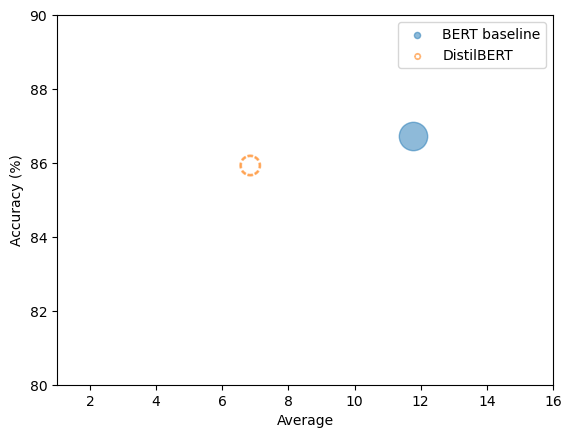

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    for idx in df.index:
        df_opt = df.loc[idx]
        cur_flag = idx == current_optim_type
        plt.scatter(
            df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
            alpha=0.5, 
            s=df_opt["size_mb"], 
            label=idx,
            marker='$\u25CC$' if cur_flag else None
        )

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 5)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average")

    
plot_metrics(perf_metrics, optim_type)

# Finding Good Hyperparameters with Optuna

In [26]:
import optuna

def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2023-08-03 21:17:06,931] A new study created in memory with name: no-name-12fc5e67-18d8-44cc-bd5b-7e369734791e
[I 2023-08-03 21:17:06,933] Trial 0 finished with value: 3.006127488221701 and parameters: {'x': 0.1997337120037912, 'y': -0.11391481065846021}. Best is trial 0 with value: 3.006127488221701.
[I 2023-08-03 21:17:06,933] Trial 1 finished with value: 1147.4975325132314 and parameters: {'x': 1.3196380766337645, 'y': -1.645877835055769}. Best is trial 0 with value: 3.006127488221701.
[I 2023-08-03 21:17:06,934] Trial 2 finished with value: 109.54465090052959 and parameters: {'x': 0.7479020671136474, 'y': 1.6056896554353766}. Best is trial 0 with value: 3.006127488221701.
[I 2023-08-03 21:17:06,935] Trial 3 finished with value: 282.21986069512485 and parameters: {'x': -0.08087967297986198, 'y': -1.6699177229411468}. Best is trial 0 with value: 3.006127488221701.
[I 2023-08-03 21:17:06,935] Trial 4 finished with value: 0.4407660063396128 and parameters: {'x': 0.9701235630947682, 

In [27]:
study.best_params

{'x': 0.9226084225678899, 'y': 0.8524168735941567}

In [28]:
def hp_space(trial):
    return {
        "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)
        }

In [42]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=10, # 20
    direction="maximize", 
    hp_space=hp_space
)

[I 2023-08-03 21:32:29,163] A new study created in memory with name: no-name-f68a18d3-2d64-495f-8d7b-fd61717c7a6c
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,0.94323
eval/loss,0.13471
eval/runtime,1.2339
eval/samples_per_second,2512.435
eval/steps_per_second,52.68
train/epoch,9.0
train/global_step,2862
train/learning_rate,0.0
train/loss,0.1355
train/total_flos,743498049913920.0
train/train_loss,0.34202


  0%|          | 0/2862 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2023-08-03 21:35:05,694] Trial 0 finished with value: 0.9470967741935484 and parameters: {'num_train_epochs': 9, 'alpha': 0.9626055545682005, 'temperature': 7}. Best is trial 0 with value: 0.9470967741935484.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilB

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,0.9471
eval/loss,0.27156
eval/runtime,1.2439
eval/samples_per_second,2492.231
eval/steps_per_second,52.256
train/epoch,9.0
train/global_step,2862
train/learning_rate,0.0
train/loss,0.1368
train/total_flos,743498049913920.0
train/train_loss,1.01416


  0%|          | 0/1908 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2023-08-03 21:36:52,131] Trial 1 finished with value: 0.9332258064516129 and parameters: {'num_train_epochs': 6, 'alpha': 0.9792121411433268, 'temperature': 9}. Best is trial 0 with value: 0.9470967741935484.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilB

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,0.93323
eval/loss,0.49549
eval/runtime,1.244
eval/samples_per_second,2491.883
eval/steps_per_second,52.249
train/epoch,6.0
train/global_step,1908
train/learning_rate,0.0
train/loss,0.6806
train/total_flos,496057080049020.0
train/train_loss,1.64072


  0%|          | 0/3180 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2023-08-03 21:39:43,062] Trial 2 finished with value: 0.9470967741935484 and parameters: {'num_train_epochs': 10, 'alpha': 0.6990537803952728, 'temperature': 14}. Best is trial 0 with value: 0.9470967741935484.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Disti

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,0.9471
eval/loss,0.25491
eval/runtime,1.2518
eval/samples_per_second,2476.407
eval/steps_per_second,51.925
train/epoch,10.0
train/global_step,3180
train/learning_rate,0.0
train/loss,0.1466
train/total_flos,826338438271332.0
train/train_loss,0.7521


  0%|          | 0/1908 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2023-08-03 21:41:29,852] Trial 3 finished with value: 0.9341935483870968 and parameters: {'num_train_epochs': 6, 'alpha': 0.688989116398541, 'temperature': 6}. Best is trial 0 with value: 0.9470967741935484.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBe

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,0.93419
eval/loss,0.46104
eval/runtime,1.2416
eval/samples_per_second,2496.679
eval/steps_per_second,52.35
train/epoch,6.0
train/global_step,1908
train/learning_rate,0.0
train/loss,0.5985
train/total_flos,496057080049020.0
train/train_loss,1.27456


  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2023-08-03 21:43:02,757] Trial 4 finished with value: 0.9232258064516129 and parameters: {'num_train_epochs': 5, 'alpha': 0.1002157800482123, 'temperature': 12}. Best is trial 0 with value: 0.9470967741935484.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Distil

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,0.92323
eval/loss,0.15935
eval/runtime,1.2437
eval/samples_per_second,2492.498
eval/steps_per_second,52.262
train/epoch,5.0
train/global_step,1590
train/learning_rate,0.0
train/loss,0.1974
train/total_flos,413013830824140.0
train/train_loss,0.37533


  0%|          | 0/3180 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2023-08-03 21:45:53,956] Trial 5 finished with value: 0.9483870967741935 and parameters: {'num_train_epochs': 10, 'alpha': 0.6042155667038915, 'temperature': 20}. Best is trial 5 with value: 0.9483870967741935.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Disti

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,0.94839
eval/loss,0.23172
eval/runtime,1.2494
eval/samples_per_second,2481.115
eval/steps_per_second,52.023
train/epoch,10.0
train/global_step,3180
train/learning_rate,0.0
train/loss,0.1444
train/total_flos,826338438271332.0
train/train_loss,0.67676


  0%|          | 0/2862 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2023-08-03 21:47:25,496] Trial 6 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,0.9329
eval/loss,0.12784
eval/runtime,1.2572
eval/samples_per_second,2465.892
eval/steps_per_second,51.704
train/epoch,5.0
train/global_step,1590
train/learning_rate,1e-05
train/loss,0.1688


  0%|          | 0/2226 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2023-08-03 21:47:54,536] Trial 7 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,0.71935
eval/loss,1.11892
eval/runtime,1.2458
eval/samples_per_second,2488.36
eval/steps_per_second,52.175
train/epoch,1.0
train/global_step,318


  0%|          | 0/2862 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2023-08-03 21:48:22,769] Trial 8 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,0.72935
eval/loss,2.99543
eval/runtime,1.2473
eval/samples_per_second,2485.343
eval/steps_per_second,52.112
train/epoch,1.0
train/global_step,318


  0%|          | 0/1908 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2023-08-03 21:49:40,522] Trial 9 pruned. 


In [ ]:
best_run

BestRun(run_id='0', objective=0.9245161290322581, hyperparameters={'num_train_epochs': 9, 'alpha': 0.1917252752868609, 'temperature': 6}, run_summary=None)

In [22]:
# for k,v in best_run.hyperparameters.items():
#     setattr(student_training_args, k, v)

hyperparameters={'num_train_epochs': 10, 'alpha': 0.12468168730193585, 'temperature': 7}
for k,v in hyperparameters.items():
    setattr(student_training_args, k, v)

In [20]:
student_training_args

DistillationTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=

In [23]:
# Define a new repository to store our distilled model
distilled_ckpt = "scc-distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model, 
    args=student_training_args,
    train_dataset=clinc_enc['train'], 
    eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, 
    tokenizer=student_tokenizer
)
distil_trainer.train();

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.

  0%|          | 0/3180 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.5766053199768066, 'eval_accuracy': 0.7348387096774194, 'eval_runtime': 1.2683, 'eval_samples_per_second': 2444.229, 'eval_steps_per_second': 51.25, 'epoch': 1.0}
{'loss': 0.7599, 'learning_rate': 1.685534591194969e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.2840275168418884, 'eval_accuracy': 0.8858064516129033, 'eval_runtime': 1.2543, 'eval_samples_per_second': 2471.412, 'eval_steps_per_second': 51.82, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.1774565428495407, 'eval_accuracy': 0.9241935483870968, 'eval_runtime': 1.2557, 'eval_samples_per_second': 2468.724, 'eval_steps_per_second': 51.764, 'epoch': 3.0}
{'loss': 0.2787, 'learning_rate': 1.371069182389937e-05, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.13794302940368652, 'eval_accuracy': 0.9325806451612904, 'eval_runtime': 1.2424, 'eval_samples_per_second': 2495.232, 'eval_steps_per_second': 52.319, 'epoch': 4.0}
{'loss': 0.1594, 'learning_rate': 1.0566037735849058e-05, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.12034258246421814, 'eval_accuracy': 0.9345161290322581, 'eval_runtime': 1.2505, 'eval_samples_per_second': 2478.988, 'eval_steps_per_second': 51.979, 'epoch': 5.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.11109841614961624, 'eval_accuracy': 0.9380645161290323, 'eval_runtime': 1.2785, 'eval_samples_per_second': 2424.67, 'eval_steps_per_second': 50.84, 'epoch': 6.0}
{'loss': 0.1244, 'learning_rate': 7.421383647798742e-06, 'epoch': 6.29}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.1056160256266594, 'eval_accuracy': 0.9396774193548387, 'eval_runtime': 1.2655, 'eval_samples_per_second': 2449.601, 'eval_steps_per_second': 51.363, 'epoch': 7.0}
{'loss': 0.1102, 'learning_rate': 4.276729559748428e-06, 'epoch': 7.86}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.10200657695531845, 'eval_accuracy': 0.9419354838709677, 'eval_runtime': 1.2644, 'eval_samples_per_second': 2451.66, 'eval_steps_per_second': 51.406, 'epoch': 8.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.10025300830602646, 'eval_accuracy': 0.9409677419354838, 'eval_runtime': 1.2665, 'eval_samples_per_second': 2447.637, 'eval_steps_per_second': 51.321, 'epoch': 9.0}
{'loss': 0.1032, 'learning_rate': 1.1320754716981133e-06, 'epoch': 9.43}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.0996558666229248, 'eval_accuracy': 0.9412903225806452, 'eval_runtime': 1.2749, 'eval_samples_per_second': 2431.598, 'eval_steps_per_second': 50.985, 'epoch': 10.0}
{'train_runtime': 159.0565, 'train_samples_per_second': 958.779, 'train_steps_per_second': 19.993, 'train_loss': 0.24726619780438502, 'epoch': 10.0}


Model size(MB) - 255.88
Average latency (ms) - 6.23 +\- 0.20
Accuracy on test set - 0.866


/tmp/ipykernel_35467/4228155468.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


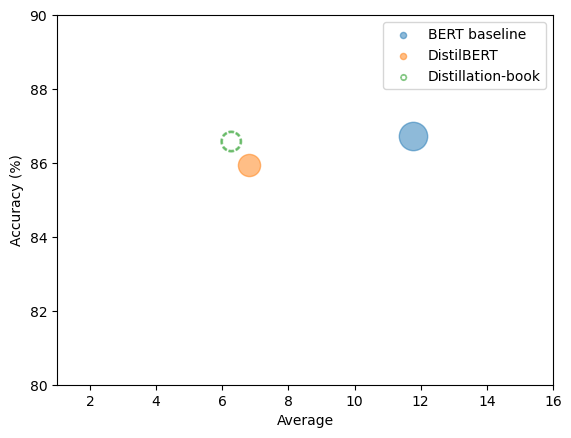

In [24]:
optim_type = "Distillation-book"
optuna_student_model = distil_trainer.model.to(torch.device('cpu'))
torch.save(optuna_student_model.state_dict(), 'optuna_student_model.ckpt')
trained_pip = pipeline("text-classification", model=optuna_student_model, config=student_config, tokenizer=student_tokenizer)

pb = PerformanceBenchmark(trained_pip, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

plot_metrics(perf_metrics, optim_type)

# Making Models Faster with Quantization


A example:  
$$137.035 = (−1)^0 \times 1.37035 \times 10^2$$

- sign: $(−1)^0$
- significand: 1.37035
- exponent: $10^2$

模型训练好之后，我们可以在不影响模型太多精度的情况下减少参数的精度。对于神经网络对于低精度数据通常使用`fix-point format`，将参数看作一个B-bit的整数再乘以一个固定的系数。比如137.035 可以看作整数`137,035`乘以系数`1/1,000`



## basic idea

离散(`discretize`)浮点数 从$[f_{max}, f_{min}]$ 映射到较小的区间$[q_{max}, q_{main}]$, 和`MaxMinScale`有些相似

`MaxMinScale`: 可能发生中心偏移
$$z_a = (a - O_{min}) / (O_{max} - O_{min}); N_a = z_a  * (N_{max} - N_{min}) + N_{min}$$
即
$$N_a = (a - O_{min})/\frac{O_{max} - O_{min}}{N_{max} - N_{min}} +  N_{min}$$


`quantize`: 直接进行映射，Z代表0值的映射变化（整体的偏移）
$$q=f/S+Z=f/\frac{f_{max} - f_{min}}{q_{max} - q_{main}} + Z$$

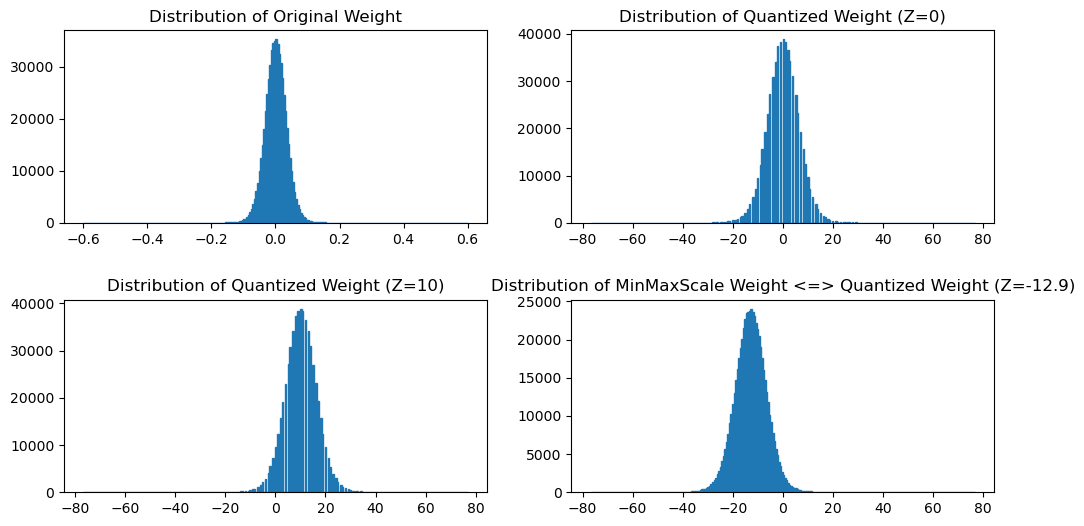

In [26]:
import matplotlib.pyplot as plt

state_dict = optuna_student_model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))
q_w = (weights / scale + zero_point).clamp(-128, 127).round().char()

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4)
axes = axes.flatten()
axes[0].hist(weights.flatten().numpy(), bins=250, range=(-0.6,0.6), edgecolor="C0") # range=(-0.3,0.3), 
axes[0].set_title('Distribution of Original Weight')

axes[1].hist(q_w.flatten().numpy(), bins=250, range=(-0.6 * 128, 0.6 *128), edgecolor="C0")
axes[1].set_title('Distribution of Quantized Weight (Z=0)')

q_w_1 = (weights / scale + 10).clamp(-128, 127).round().char()
axes[2].hist(q_w_1.flatten().numpy(), bins=250, range=(-0.6 * 128, 0.6 *128), edgecolor="C0")
axes[2].set_title('Distribution of Quantized Weight (Z=10)')

mm_q = (weights - weights.min()) / scale + (-128)
Z_ = -weights.min()/scale -128
axes[3].hist(mm_q.flatten().numpy(), bins=250, range=(-0.6 * 128, 0.6 *128), edgecolor="C0")
axes[3].set_title(f'Distribution of MinMaxScale Weight <=> Quantized Weight (Z={Z_:.1f})')
plt.show()

In [24]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   0,   6,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -8, -14],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [25]:
from torch.nn.quantized import QFunctional
q_fn = QFunctional()

In [26]:
%%timeit
weights @ weights

1.34 ms ± 9.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [27]:
%%timeit
# NT8 tensors is almost 100 times faster!
q_fn.mul(quantized_weights, quantized_weights)

96.2 µs ± 145 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
import sys
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

/tmp/ipykernel_30079/2122423139.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

## Three main approaches to quantization

1. Dynamic quantization: 
    - When using dynamic quantization nothing is changed during training and the adaptations are only performed during inference.
    - model are converted to INT8 ahead of inference time
    - This conversion between integer and floating point can be a performance bottleneck
2. Static quantization
    - 非动态计算激活函数量化，we can avoid the conversion to floating point by precomputing the quantization scheme.

In [27]:
# dynamic quantization in PyTorch
from torch.quantization import quantize_dynamic

In [28]:
tokenizer = student_tokenizer
model = optuna_student_model.to("cpu")

In [29]:
# dtype = fp16 or qint8.
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

In [30]:
pipe = pipeline("text-classification", model=model_quantized, tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size(MB) - 132.39
Average latency (ms) - 3.58 +\- 0.31
Accuracy on test set - 0.874


/tmp/ipykernel_35467/4228155468.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


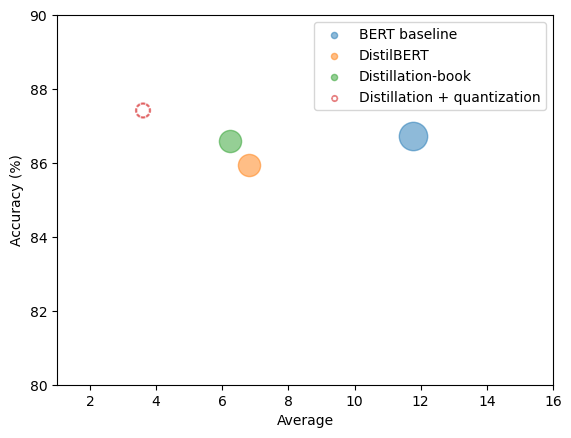

In [31]:
# the quantized model is almost half the size of our distilled one and has even gained a slight accuracy boost
plot_metrics(perf_metrics, optim_type)

### Optimizing Inference with ONNX and the ONNX Runtime

Transformers library has a built-in function called `convert_graph_to_onnx.convert()` that simplifies the process by taking the following
steps:
1. Initialize the model as a Pipeline.
2. Run placeholder inputs through the pipeline so that ONNX can record the computational graph.
3. Define dynamic axes to handle dynamic sequence lengths.
4. Save the graph with network parameters.

In [66]:
import os
from psutil import cpu_count
# first need to set some OpenMP environment variables for ONNX
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"
print(os.environ["OMP_NUM_THREADS"])

20


In [84]:
from transformers.convert_graph_to_onnx import convert_pytorch
# 1. Initialize the model as a Pipeline.
optuna_student_model = distil_trainer.model.to(torch.device('cpu'))
pipe = pipeline("text-classification", model=optuna_student_model, tokenizer=tokenizer, framework='pt')
onnx_model_path = Path("onnx/model.onnx")
convert_pytorch(
    pipe, 
    opset=12, 
    output=onnx_model_path, 
    use_external_format=False
)

Using framework PyTorch: 2.0.1+cu117
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']
============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [85]:
from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions

def create_model_for_provider(model_path, provider='CPUExecutionProvider'): 
    opt = SessionOptions()
    opt.intra_op_num_threads = 1
    opt.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), opt, providers=[provider])
    session.disable_fallback()
    return session

onnx_model = create_model_for_provider(onnx_model_path)

In [86]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [87]:
np.argmax(logits_onnx), clinc_enc["test"][0]["labels"]

(61, 61)

In [88]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
    
    def __call__(self, query):
        model_ipts = self.tokenizer(query, return_tensors='pt')
        inputs_onnx = {k: v.cpu().detach().numpy()  for k, v in model_ipts.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{'label': intents.int2str(pred_idx), 'score': probs[pred_idx]}]


In [89]:
query

"Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in\nParis and I need a 15 passenger van"

In [90]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.767457}]

In [91]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
    
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [92]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(
    pipe, clinc["test"], 
    optim_type,
    model_path="onnx/model.onnx"
)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Average latency (ms) - 11.96 +\- 0.48
Accuracy on test set - 0.866


In [95]:
del perf_metrics['Distillation + ORT (quantized)']

/tmp/ipykernel_35467/4228155468.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


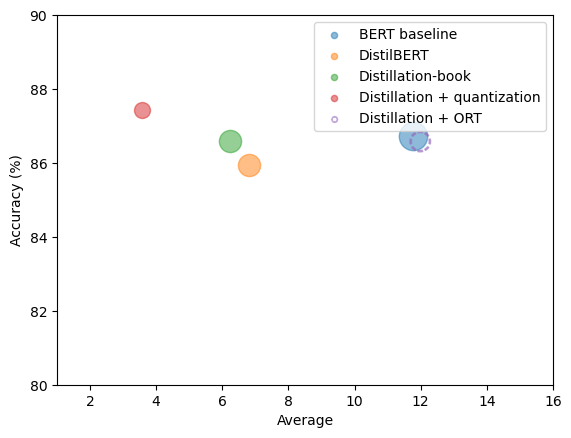

In [96]:
plot_metrics(perf_metrics, optim_type)

In [97]:
from onnxruntime.quantization import quantize_dynamic, QuantType
model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [98]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.33
Average latency (ms) - 4.02 +\- 0.19
Accuracy on test set - 0.873


/tmp/ipykernel_35467/4228155468.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


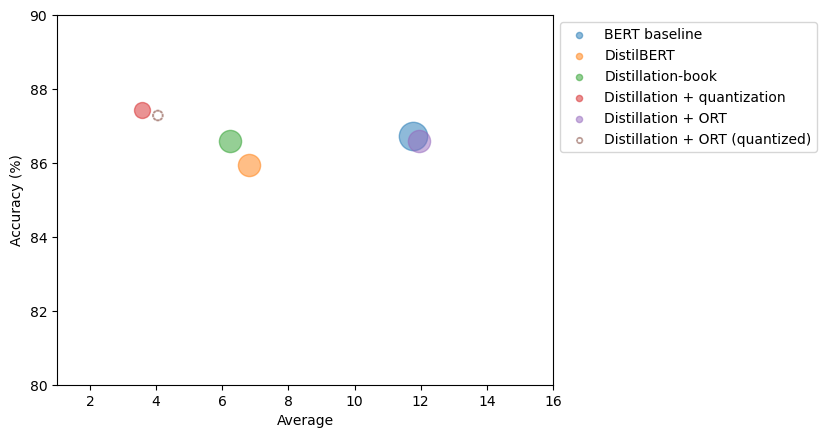

In [99]:
plot_metrics(perf_metrics, optim_type)

In [100]:
perf_metrics

{'BERT baseline': {'size_mb': 418.14669132232666,
  'time_avg_ms': 11.761012869956176,
  'time_std_ms': 0.5611672479846492,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88143634796143,
  'time_avg_ms': 6.809393349994934,
  'time_std_ms': 0.38138947797170525,
  'accuracy': 0.8594545454545455},
 'Distillation-book': {'size_mb': 255.88143634796143,
  'time_avg_ms': 6.230678819956665,
  'time_std_ms': 0.20307298678446475,
  'accuracy': 0.8658181818181818},
 'Distillation + quantization': {'size_mb': 132.3907289505005,
  'time_avg_ms': 3.583047990050545,
  'time_std_ms': 0.3067817499987456,
  'accuracy': 0.8743636363636363},
 'Distillation + ORT': {'size_mb': 255.97955417633057,
  'time_avg_ms': 11.955346350114269,
  'time_std_ms': 0.48448113801969656,
  'accuracy': 0.8658181818181818},
 'Distillation + ORT (quantized)': {'size_mb': 64.32713317871094,
  'time_avg_ms': 4.0221518100224785,
  'time_std_ms': 0.19119038572709968,
  'accuracy': 0.8730909090909091}}

Summary
- Depend on CPU:  The performance(size_mb, time_avg_ms) of **Distillation + ORT** may didn't better than  **Distillation** 
- <font color=darkred>Always The best Choice</font>: **Distillation + ORT (quantized)**
- The 2nd Choice: **Distillation + quantized**

/tmp/ipykernel_27/4228155468.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


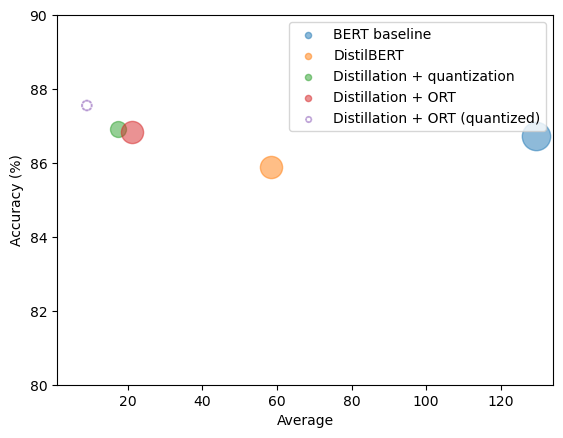

In [53]:
# The Kaggle result
plot_metrics(perf_metrics, optim_type)

### Making Models Sparser with Weight Pruning

Mathematically, 一般`pruning`方法就是计算参数的重要性，取TopK

$$Top_k(S)_{ij}=
\begin{cases}
1 \text{   if } S_{ij}\text{ in top } \mathcal(k)\% \\
0 \text{   otherwise}
\end{cases}
\tag{1}
$$
